In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
class AnalysisSettings():
    def __init__(self, dataset) -> None:
        self.dataset = dataset
        match self.dataset:
            case 'iris':
                self.label_pos = 4
                self.attribute_pos = [0, 1, 2, 3]
            case 'wine':
                self.label_pos = 0
                self.attribute_pos = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
            case 'mnist':
                self.label_pos = 0
                self.attribute_pos = [i for i in range(1, 785)]
            

In [4]:
# Load data from dataset
settings = AnalysisSettings('mnist')

load_path = './experiments/inference/results/' + settings.dataset + '/'
org_dataset = pd.read_csv(load_path + 'original.csv', index_col=0)

## Plotting samples of disturbed data

In [40]:
sparsity = 0.05

# Load data and mask from dataset with sparsity
mask = pd.read_csv(load_path + str(sparsity) + '/mask.csv', index_col=0)
masked_dataset = org_dataset.drop(['label'], axis=1) * ~mask

In [42]:
# Replacing the masked values with the middle values of the max possible values
masked_dataset[mask] = 256 / 2


In [73]:
# Loading the reconstructed datasets from pcn and knn
pcn_dataset = pd.read_csv(load_path + str(sparsity) + '/pcn.csv', index_col=0)
knn_dataset = pd.read_csv(load_path + str(sparsity) + '/knn.csv', index_col=0)

pcn_samples = pcn_dataset.drop(['label'], axis=1)
knn_samples = knn_dataset.drop(['label'], axis=1)

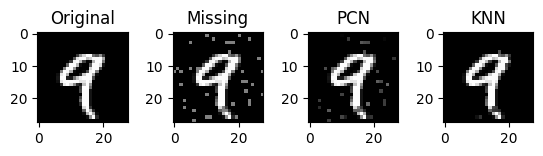

In [76]:
# Plotting one sample for each output class
for i in range(10):
    sample = org_dataset[org_dataset['label'] == i].index[0]
    ax0 = plt.subplot(1, 4, 1)
    plt.title('Original')
    plt.imshow(org_dataset.drop(['label'], axis=1).iloc[sample].values.reshape(28, 28), cmap='gray')

    ax1 = plt.subplot(1, 4, 2)
    plt.title('Missing')
    plt.imshow(masked_dataset.iloc[sample].values.reshape(28, 28), cmap='gray')

    ax2 = plt.subplot(1, 4, 3)
    plt.title('PCN')
    plt.imshow(pcn_samples.iloc[sample].values.reshape(28, 28), cmap='gray')

    ax3 = plt.subplot(1, 4, 4)
    plt.title('KNN')
    plt.imshow(knn_samples.iloc[sample].values.reshape(28, 28), cmap='gray')

    plt.subplots_adjust(wspace=0.5)
    # plt.show()

    # Saving the output to file
    save_path = './experiments/inference/image/' + settings.dataset + '/reconstructed_' + str(i) + '.png'
    plt.savefig(save_path, bbox_inches='tight')

## Analysis of average accuracy of agents trained on reconstructed dataset

In [88]:
# Find mean accuracy on the control set
control_df = pd.read_csv('./experiments/inference/results/' + settings.dataset + '/control_acc_test.csv', index_col=0)
# acc_ann_control, acc_pcn_control = control_df.mean(axis=0).values
acc_ann_control, acc_pcn_control, acc_ann_control_train, acc_pcn_control_train = control_df.mean(axis=0).values

In [89]:
# Find accuracy on sparse dataset of knn and pcn reconstructed datasets for each sparsity
test_accs_knn_ann = []
test_accs_knn_pcn = []
test_accs_pcn_ann = []
test_accs_pcn_pcn = []
train_accs_knn_ann = []
train_accs_knn_pcn = []
train_accs_pcn_ann = []
train_accs_pcn_pcn = []

test_accs = np.zeros((len(sparsity), 2, 2)) # Sparsity, PCN/KNN, PCN/ANN
train_accs = np.zeros((len(sparsity), 2, 2)) # Sparsity, PCN/KNN, PCN/ANN

TRAIN = 0
TEST = 0
PCN = 1
KNN = 0
ANN = 0

for i, s in enumerate(sparsity):
    knn_test_df = pd.read_csv('./experiments/inference/results/' + settings.dataset + '/knn_reconstructed/' + str(s) + 'acc_test.csv', index_col=0)
    pcn_test_df = pd.read_csv('./experiments/inference/results/' + settings.dataset + '/pcn_reconstructed/' + str(s) + 'acc_test.csv', index_col=0)

    knn_train_df = pd.read_csv('./experiments/inference/results/' + settings.dataset + '/knn_reconstructed/' + str(s) + 'acc_train.csv', index_col=0)
    pcn_train_df = pd.read_csv('./experiments/inference/results/' + settings.dataset + '/pcn_reconstructed/' + str(s) + 'acc_train.csv', index_col=0)
    
    knn_ann_test, knn_pcn_test = knn_test_df.mean().values
    pcn_ann_test, pcn_pcn_test = pcn_test_df.mean().values

    knn_ann_train, knn_pcn_train = knn_train_df.mean().values
    pcn_ann_train, pcn_pcn_train = pcn_train_df.mean().values

    test_accs[i, PCN] = pcn_test_df.mean().values
    test_accs[i, KNN] = knn_test_df.mean().values

    train_accs[i, PCN] = pcn_train_df.mean().values
    train_accs[i, KNN] = knn_train_df.mean().values

test_accs


array([[[0.5  , 0.922],
        [0.5  , 0.925]],

       [[0.5  , 0.917],
        [0.5  , 0.922]],

       [[0.5  , 0.914],
        [0.5  , 0.908]],

       [[0.5  , 0.925],
        [0.5  , 0.914]],

       [[0.5  , 0.933],
        [0.5  , 0.931]]])

In [90]:
# Improvements
np.mean(test_accs, axis=0) - np.array([acc_ann_control, acc_pcn_control])

array([[-0.183, -0.011],
       [-0.183, -0.013]])

In [91]:
# Importments on training set
np.mean(train_accs, axis=0) - np.array([acc_ann_control_train, acc_pcn_control_train])

array([[-0.181, -0.011],
       [-0.181, -0.012]])